In [2]:
from IPython import embed
import numpy as np

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.modeling.fitting import LevMarLSQFitter

from photutils import IRAFStarFinder
from photutils import CircularAperture
from photutils.psf import IterativePSFPhotometry
from photutils.background import MMMBackground, MADStdBackgroundRMS, LocalBackground
from photutils.psf import IntegratedGaussianPRF, SourceGrouper
from photutils.aperture import ApertureStats

from pathlib import Path
# from fits_convenience_class import Fits_Simple
from astropy.table import Table
import warnings

from matplotlib import pyplot as plt
from astropy.visualization import ZScaleInterval
from astropy.modeling.fitting import LevMarLSQFitter

from collections import OrderedDict
from reduction_mod_basic import process_single

from scipy import stats
from scipy.interpolate import griddata
from astropy.stats import SigmaClip
from loess.loess_2d import loess_2d

from old_fits_convenience_class import Fits_Simple

# import os
# import sys
# current_dir = os.path.dirname(os.path.abspath(__file__))
# parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
# sys.path.append(parent_dir)
# from fits_convenience_class import Fits_Simple


def testing():
    # directories = [Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-06-24/raw-reduced/109_199_{filt}') for filt in ['B', 'V', 'R', 'I']]

    rawdir = Path("")
    rawdir = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw")  # path to directory with raw data

    image_to_analyze = Path("C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw/d1079.fits")  # path to directory with raw data

    # Initial configuration
    # directories = [Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-06-24/raw-reduced/PG1530+057_{filt}') for filt in ['B', 'V', 'R', 'I']]
    # Night 1 mod
    # directories = [Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-06-24/raw-reduced/109_231_{filt}') for filt in ['R']]

    # reddir = Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-05-12/raw-reduced/')
    # directories = [dir for dir in reddir.iterdir() if 'flat' not in str(dir)]

    # reddir = Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-06-26/raw-reduced/')
    # directories = [dir for dir in reddir.iterdir() if ('Focus' not in str(dir) and 'NGC' not in str(dir))]
    # graph_fwhms_by_setting(directories, condition_tuples=conditions_06_26)
    
    # reddir = Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-06-26/raw-reduced/')
    # directories = [dir for dir in reddir.iterdir() if ('Focus' not in str(dir) and 'NGC' not in str(dir))]
    # graph_fwhms_by_setting(directories, condition_tuples=conditions_06_26)

    # reddir = Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-06-26/raw-reduced/')
    # directories = [dir for dir in reddir.iterdir() if ('109_199' in str(dir))]
    # graph_fwhms_by_image(directories, '06-26-24')

    # bias, flat = generate_reduction_files(rawdir)
    # fwhm = fwhm_from_raw(image_to_analyze, bias, flat)

default_fwhm_default=5.0
thresh_default=15
aper_size_default=8
local_bkg_range_default=(15,20)


def plot_sources(f, img, x, y, given_fwhm, ofile=None):
    positions = np.transpose((x, y))
    apertures = CircularAperture(positions, r=2*given_fwhm)
    # Apply ZScaleInterval
    interval = ZScaleInterval()
    vmin, vmax = interval.get_limits(img)
    plt.imshow(img, origin='lower', vmin=vmin, vmax=vmax,
                  interpolation='nearest')
    plt.colorbar()
    apertures.plot(color='r', lw=1.5, alpha=0.5)
    plt.show()


def calc_fwhm(image, mode='psf', plot=False, default_fwhm=default_fwhm_default, thresh=thresh_default,
         aper_size=aper_size_default, local_bkg_range=local_bkg_range_default,
         which_source=None):
    if not isinstance(image, Fits_Simple):
        image = Fits_Simple(image)
    
    sig2fwhm = np.sqrt(8*np.log(2))
    # aper_size = 1.5*default_fwhm/2

    unmasked_img = image.data
    # Mask specific columns
    columns_to_mask = [255, 256, 783, 784, 1002]
    column_mask = np.zeros(unmasked_img.shape[1], dtype=bool)
    column_mask[columns_to_mask] = True

    # Create a masked array with the masked columns
    img = np.ma.masked_array(unmasked_img, mask=np.zeros_like(unmasked_img, dtype=bool))
    img.mask[:, column_mask] = True

    # Mask specific rows (sections)
    rows_to_mask = np.arange(0, 5).tolist() + np.arange(unmasked_img.shape[0]-50, unmasked_img.shape[0]).tolist()
    row_mask = np.zeros(unmasked_img.shape[0], dtype=bool)
    row_mask[rows_to_mask] = True

    # Update the masked array to include the masked rows
    img.mask[row_mask, :] = True
    
    # print(img.data)
    
    # img = np.delete(img, [255, 256, 783, 784, 1002], axis=1)
    # img = img[5:-50, 5:-50]

    #----------------------------------------------------------------------
    # Do a first source detection using the default FWHM
    #----------------------------------------------------------------------
    _, median, std = sigma_clipped_stats(img, sigma=3.)
    starfind = IRAFStarFinder(fwhm=default_fwhm, threshold=thresh*std,
                              minsep_fwhm=0.1, sky=0.0, peakmax=55000,)
    sources = starfind(data=(img.data - median), mask=img.mask)
    # print(f'Found {len(sources)} sources in {image}.')
    # This determines the distance of each source to every other
    # source and removes sources that are too close to one another
    i, j = np.meshgrid(np.arange(len(sources)), np.arange(len(sources)),
                            indexing='ij')
    dist = np.sqrt(np.square(sources['xcentroid'][:,None]
                             - sources['xcentroid'][None,:])
                + np.square(sources['ycentroid'][:,None]
                            - sources['ycentroid'][None,:]))
    indx = (dist < default_fwhm/1.7) & (j > i)
    sources = sources[np.logical_not(np.any(indx, axis=0))]

    #----------------------------------------------------------------------
    # Attempt to improve the source detection by improving the FWHM estimate
    #----------------------------------------------------------------------
    win = int(np.ceil(2*default_fwhm))
    if win % 2 == 0:
        win += 1
    bkgrms = MADStdBackgroundRMS()
    std = bkgrms(img)
    # Source finder
    iraffind = IRAFStarFinder(fwhm=default_fwhm, threshold=thresh*std, 
                              minsep_fwhm=0.1, peakmax=55000)
    grouper = SourceGrouper(min_separation=2*default_fwhm)  # Grouping algorithm
    mmm_bkg = MMMBackground()   # Background-determining function
    local_bkg = LocalBackground(*local_bkg_range, mmm_bkg)
    fitter = LevMarLSQFitter()  # This is the optimization algorithm
    # This is the model of the PSF
    gaussian_prf = IntegratedGaussianPRF(sigma=default_fwhm/sig2fwhm)
    gaussian_prf.sigma.fixed = False    # Turn off fixing the sigma to be a constant
    # This is the object that performs the photometry
    phot = IterativePSFPhotometry(finder=iraffind,
                                  grouper=grouper,
                                  localbkg_estimator=local_bkg, psf_model=gaussian_prf,
                                  fitter=fitter, fit_shape=win, maxiters=4,
                                  fitter_maxiters=4, aperture_radius = aper_size)
    # This is actually when the fitting is done
    phot_data = phot(data=img.data, mask=img.mask,
                     init_params=Table(sources['xcentroid', 'ycentroid', 'flux'],
                                       names=('x_0', 'y_0', 'flux_0')))

    indx = phot_data['iter_detected'] == 1
    fwhm = np.median(phot_data['sigma_fit'][indx])*sig2fwhm
    
    #----------------------------------------------------------------------
    # Refit using the "improved" FWHM
    #----------------------------------------------------------------------

    iraffind = IRAFStarFinder(fwhm=fwhm, threshold=thresh*std,
                              minsep_fwhm=0.1, peakmax=55000)
    grouper = SourceGrouper(min_separation=2*fwhm)
    gaussian_prf = IntegratedGaussianPRF(sigma=fwhm/sig2fwhm)
    gaussian_prf.sigma.fixed = False
    phot = IterativePSFPhotometry(finder=iraffind,
                                  grouper=grouper,
                                  localbkg_estimator=local_bkg, psf_model=gaussian_prf,
                                  fitter=fitter, fit_shape=win, maxiters=2,
                                  fitter_maxiters=2, aperture_radius = aper_size)
    phot_data = phot(data=img.data, mask=img.mask,
                     init_params=Table([phot_data['x_fit'][indx],
                                        phot_data['y_fit'][indx],
                                        phot_data['flux_fit'][indx]],
                                        names=('x_0', 'y_0', 'flux_0')))
    #----------------------------------------------------------------------
    # Extract the source which_source, & calculate fwhm
    #----------------------------------------------------------------------

    # Extracts only the which_source brightest src from phot_data to analyze
    if which_source is not None:
        phot_data = phot_data[phot_data['iter_detected']]
        indices_by_peak = phot_data.argsort('flux_init')
        chosen_star = indices_by_peak[which_source]
        print(f"flux of star chosen = {phot_data['flux_init'][chosen_star]}")
        phot_data = phot_data[indices_by_peak[chosen_star]]
    
    indx = phot_data['iter_detected'] == 1
    psf_fwhm_median = np.median(phot_data['sigma_fit'][indx])*sig2fwhm
    psf_fwhm_std = np.std(phot_data['sigma_fit'][indx]*sig2fwhm)

    if plot:
        plot_sources(image, img, phot_data['x_fit'][indx], phot_data['y_fit'][indx],fwhm)
    
    #----------------------------------------------------------------------
    # Testing AperatureStats
    #----------------------------------------------------------------------
    if mode == 'aper':
        coordinates = list(zip(phot_data['x_fit'][indx], phot_data['y_fit'][indx]))
        local_bkg_values = local_bkg(img, phot_data['x_fit'][indx], phot_data['y_fit'][indx])
        apertures = CircularAperture(coordinates, r=aper_size)
        aperstats = ApertureStats(img, apertures, local_bkg=local_bkg_values)
        
        aper_fwhm = aperstats.fwhm
        aper_fwhm_median = np.nanmedian(aper_fwhm)
        aper_fwhm_std = np.nanstd(aper_fwhm)

    #----------------------------------------------------------------------
    # Return
    #----------------------------------------------------------------------
    # (psf_fwhm_median, aper_fwhm_median, psf_fwhm_std, aper_fwhm_std)
    if mode == 'psf':
        return psf_fwhm_median, psf_fwhm_std
    elif mode == 'aper':
        return aper_fwhm_median
    elif mode == 'all fwhms':
        return phot_data['sigma_fit'][indx]*sig2fwhm, psf_fwhm_std
    elif mode == 'fwhm residuals':
        all_fwhms = np.array(phot_data['sigma_fit'][indx])*sig2fwhm
        all_x = np.array(phot_data['x_fit'][indx])
        all_y = np.array(phot_data['y_fit'][indx])
        
        # Create a SigmaClip object and apply it to get a mask
        sigma_clip = SigmaClip(sigma=3, maxiters=5)
        masked_fwhms = sigma_clip(all_fwhms)

        # Apply the mask to the original data
        clipped_x = np.array(all_x)[~masked_fwhms.mask]
        clipped_y = np.array(all_y)[~masked_fwhms.mask]
        clipped_fwhms = np.array(all_fwhms)[~masked_fwhms.mask]
        
        # Calculate the residuals wrt the minimum FWHM
        # Approximating "removing" the atmospheric FWHM, leaving (mostly) the telescopic
        min_fwhm = np.min(clipped_fwhms)
        fwhm_residuals = np.sqrt(clipped_fwhms**2 - min_fwhm**2)
        # print("Number of sources removed =", len(all_x) - len(clipped_x))
        # print(clipped_fwhms)
        # print("min_fwhm = ", min_fwhm)
        # print(fwhm_residuals)
        
        return (clipped_x, clipped_y, fwhm_residuals)
    else:
        return "mode must = 'psf', 'aper', 'all fwhms', or 'fwhm coords'"


def fwhm_from_raw(image, bias, flat):
    image = Path(image)
    reduced_image = process_single(image, bias, flat)
    fwhm = calc_fwhm(reduced_image)
    print(f"FWHM for image {image.name} = {fwhm}")
    return fwhm


def batch_fwhm(directories, files=None, plot=False, max_std=0.5, mode='psf'):
    images = unzip_directories(directories, files, output_format='Fits_Simple')
    
    fwhms = []
    stds = []
    data = []
    for image in images:
        try:
            fwhm, std = calc_fwhm(image, plot=plot, mode=mode)
        except TypeError as e:
            print(f"No sources detected in {image} -- {e}")
        print(f"FWHM for image {image} = {fwhm} pix")
        print(f"STD for image {image} = {std} pix")
        if std < max_std:
            data.append((int(image.image_num), fwhm, std, image.object))#f"{image.object} - {image.filtnam}"))
    
    image_numbers, fwhms, stds, objects = zip(*data)

    avg = np.mean(np.hstack(fwhms))
    print(f'Mean FWHM for all images = {avg}')
    avg_std = np.mean(stds)
    print(f'Mean of individual images STDs = {avg_std}')
    std = np.std(np.hstack(fwhms))
    print(f'STD for average FWHM measurements = {std}')
    
    return avg, data


def avg_fwhm(directories, files=None, plot=False, max_std=0.5):
    avg, _ = batch_fwhm(directories, files=files, plot=plot, max_std=max_std)
    return avg


def graph_fwhms_by_image(directories, date=None, files=None, plot=False, max_std=0.5):
    avg, data = batch_fwhm(directories, plot=plot, files=files, max_std=max_std)
    data.sort()
    image_numbers, fwhms, stds, objects = zip(*data)
    unique_objects = list(OrderedDict.fromkeys(objects))
    if date is None:
        print("Date in title may be inaccurate")
        date = directories[0].parent.parent.name[-5:]

    # Plot the values relative to image numbers, with different colors for different objects
    plt.figure(figsize=(10, 6))
    plt.plot(image_numbers, fwhms, marker='o', linestyle='-', color='#808080', zorder=1, label='FWHM')
    plt.plot(image_numbers, stds, marker='s', linestyle='-', color='#B3B3B3', zorder=1, label='STD')
    for obj in unique_objects:
        obj_data = [(img_num, fwhm, std) for img_num, fwhm, std, obj_name in data if obj_name == obj]
        obj_image_numbers, obj_fwhms, obj_stds = zip(*obj_data)
        # plt.scatter(obj_image_numbers, obj_stds, marker='s', label=obj, zorder=2)
        plt.scatter(obj_image_numbers, obj_fwhms, marker='o', label=obj, zorder=2)  # Add lines and points
    
    plt.xlabel('Image Number')
    plt.ylabel('FWHM Value')
    plt.title(f'FWHM Value vs. Image Number - {date}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    min_num = min(image_numbers)
    max_num = max(image_numbers)
    plt.xticks(range(min_num, max_num + 1, max(1, int((max_num-min_num)/20))))
    plt.show()

    return avg


def graph_fwhms_by_setting(directories, condition_tuples, files=None):
    
    images = unzip_directories(directories, files, output_format='Fits_Simple')
    
    categories = categories_from_conditions(condition_tuples, images)
    
    data = []
    conf_intervals = []
    # Print out the categories and their corresponding file lists
    for category, file_list in categories.items():
        mean_fwhm, result_matrix = batch_fwhm(None, files=file_list, mode='all fwhms')
        data.append((category, mean_fwhm))

        # std/sqrt(n) = standard error (in/of the mean)

        image_numbers, fwhms, stds, objects = zip(*result_matrix)
        fwhms = np.hstack(fwhms).tolist()
        std_dev = np.std(fwhms, ddof=1) # Sample standard deviation
        
        confidence_level = 0.95 # Confidence level
        # Calculate the t-critical value
        t_critical = stats.t.ppf((1 + confidence_level) / 2, df=len(fwhms)-1)
        # Calculate the margin of error
        # margin_of_error = t_critical * (std_dev / np.sqrt(len(fwhms)))
        
        margin_of_error = std_dev / np.sqrt(len(fwhms))
        # Calculate the confidence interval
        # conf_intervals.append((margin_of_error,
        #                        margin_of_error))
        interval = stats.norm.interval(confidence=0.95, 
                                       loc=np.mean(fwhms), 
                                       scale=stats.sem(fwhms))
        conf_intervals.append((abs((interval[0] - mean_fwhm)), 
                               abs(interval[1] - mean_fwhm)))
    
    data.sort()
    widths, fwhms = zip(*data)
    conf_intervals = np.array(conf_intervals).T
    
    # Plot the plate_scales relative to widths, with different colors for different objects
    plt.figure(figsize=(8, 5))
    plt.errorbar(widths, fwhms, yerr=[conf_intervals[0], conf_intervals[1]], 
                 fmt='o', linestyle='-', ecolor='r', capsize=5, 
                 label=f'FWHM w/ {confidence_level*100}% Conf. Interval')
    plt.xlabel('Spacer Width (in)')
    plt.ylabel('FWHM (pixels)')
    plt.title(f'FWHM vs. Spacer Width')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    return data


def single_graph_topographic(directories, files=None, title="", frac=0.5):
    
    images = unzip_directories(directories, files, output_format='Fits_Simple')
    
    # Collect all coordinates and FWHMs in numpy arrays
    all_x, all_y, all_residuals = zip(*(calc_fwhm(image, mode='fwhm residuals') 
                                        for image in images))
    all_x = np.concatenate(all_x)
    all_y = np.concatenate(all_y)
    all_residuals = np.concatenate(all_residuals)
    
    # Create grid for interpolation
    grid_x, grid_y = np.mgrid[0:1024:3, 0:1024:3]
    
    # Interpolate data using griddate
    # grid_z = griddata((clipped_x, clipped_y), clipped_fwhm, (grid_x, grid_y), method='linear')
    
    # Interpolate data using Loess smoothing - computationally difficult
    # print('loess_2d beginning')
    flat_z, wout = loess_2d(all_x, all_y, all_residuals, xnew=grid_x.flatten(),
                      ynew=grid_y.flatten(), frac=frac)
    # print('loess_2d done')
    grid_z = flat_z.reshape(grid_x.shape)
    
    # Define the colors & range of contour levels
    colors = ["#cc0018", "#cd0000", "#cb4000", "#c97f00", "#c7bc00", "#91c400", "#52c200", 
              "#00bc62", "#00ba9c", "#009cb8", "#0061b6", "#1100b1", "#4800af", "#7e00ad"]
    levels = np.linspace(0.0, 3.0, len(colors))
    # levels = np.linspace(4.5, 7.5, 10)
    # colors = ["#b70000", "#b64d00", "#b59a00", "#82b300", "#00b117", 
    #           "#00afab", "#0067ae", "#001dac", "#2c00ab", "#7400aa"]
    
    # Plot contour map
    plt.figure()
    cp = plt.contourf(grid_x, grid_y, grid_z, levels=levels, colors=colors)
    plt.colorbar(cp)
    plt.title(f'FWHM Contour Map - {title}')
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    plt.show()
    

def graph_topographic(directories, condition_tuples, files=None, frac=0.5):
    
    images = unzip_directories(directories, files, output_format='Fits_Simple')
    categories = categories_from_conditions(condition_tuples, images)
    
    for category, file_list in categories.items():
        single_graph_topographic(None, files=file_list, title=category, frac=frac)


def categories_from_conditions(condition_tuples, images):
    # Initialize an empty dictionary
    conditions = {}
    # Process the input list
    for value, (start, end) in condition_tuples:
        if value in conditions:
            conditions[value].append((start, end))
        else:
            conditions[value] = [(start, end)]

    # Convert ranges to lambda functions
    conditions = {width: (lambda ranges: lambda img_num: any(start <= img_num <= end for start, end in ranges))(ranges) for width, ranges in conditions.items()}
    # Use dictionary comprehension to create the categories
    categories = {width: [file.path for file in images if condition(file.image_num)] for width, condition in conditions.items()}
    return categories


def unzip_directories(directories, files=None, output_format='Fits_Simple'):
    if output_format == 'Path':
        output = Path
    elif output_format == 'Fits_Simple':
        output = Fits_Simple
    
    if files is not None:
        images = [output(file) for file in files]
    else:
        if not isinstance(directories, list):
            directories = [directories,]
        images = []
        for dir in directories:
            images += [output(file) for file in Path(dir).iterdir()]
    return images




conditions_06_26 = [(1.375, (65, 74)),
                    (1.625, (22, 31)),
                    (1.625, (88, 105)),
                    (1.875, (33, 42)),
                    (2.625, (43, 53)),
                    (3.375, (54, 64)),
                    ]

    
warnings.filterwarnings('ignore')

C:\Users\allis\AppData\Local\Temp\ipykernel_36340\1099447208.py:8: DeprecationWarning: `photutils.IRAFStarFinder` is a deprecated alias for `photutils.detection.IRAFStarFinder` and will be removed in the future. Instead, please use `from photutils.detection import IRAFStarFinder` to silence this warning.
  from photutils import IRAFStarFinder
C:\Users\allis\AppData\Local\Temp\ipykernel_36340\1099447208.py:9: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import CircularAperture


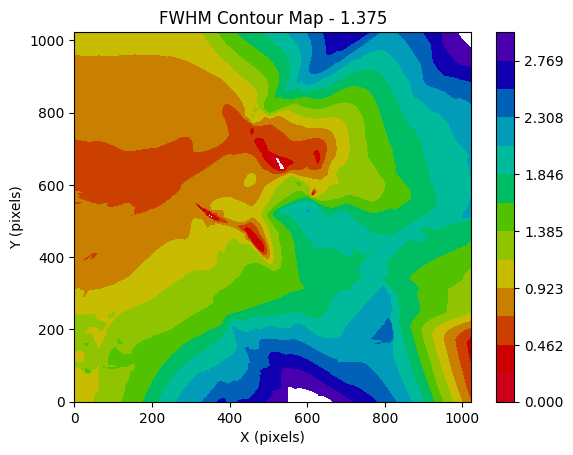

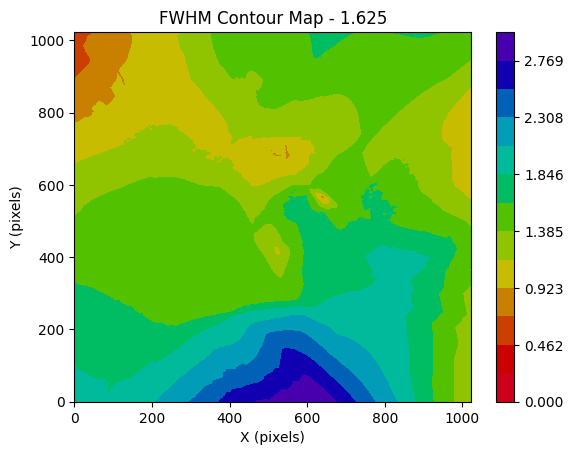

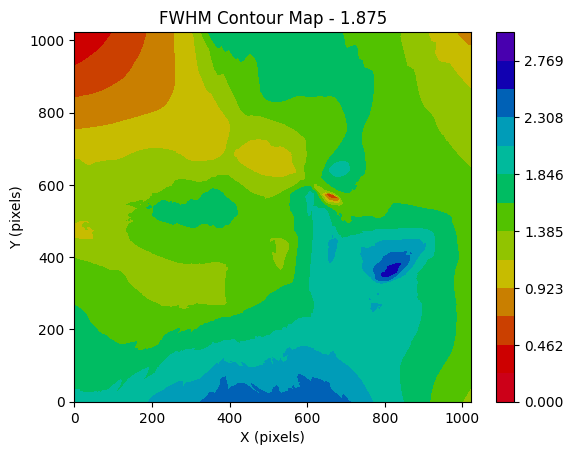

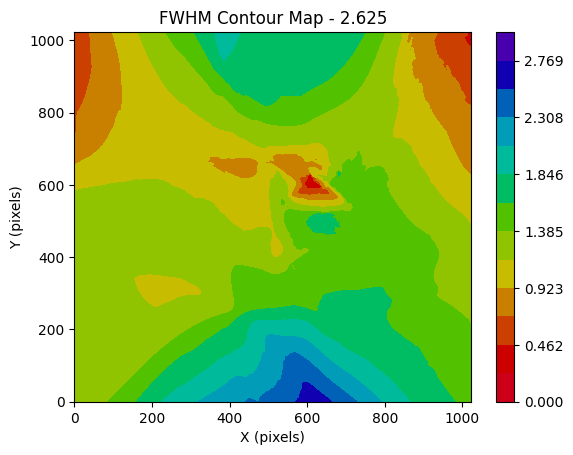

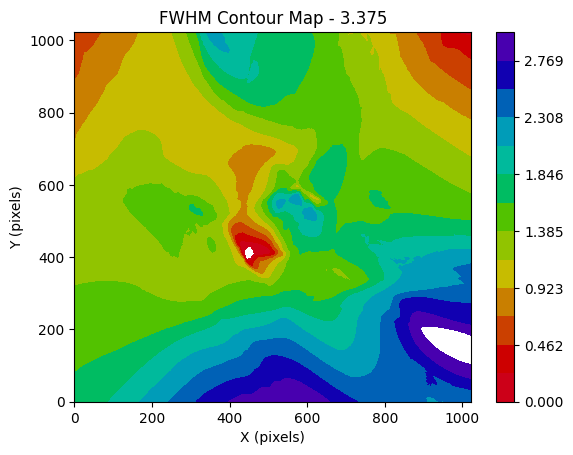

In [3]:
reddir = Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-06-26/raw-reduced/')
directories = [dir for dir in reddir.iterdir() if ('Focus' not in str(dir) and 'NGC' not in str(dir))]
graph_topographic(directories, condition_tuples=conditions_06_26, frac=0.3)

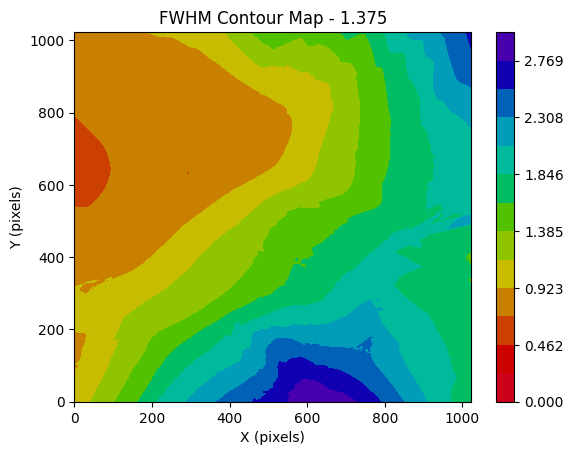

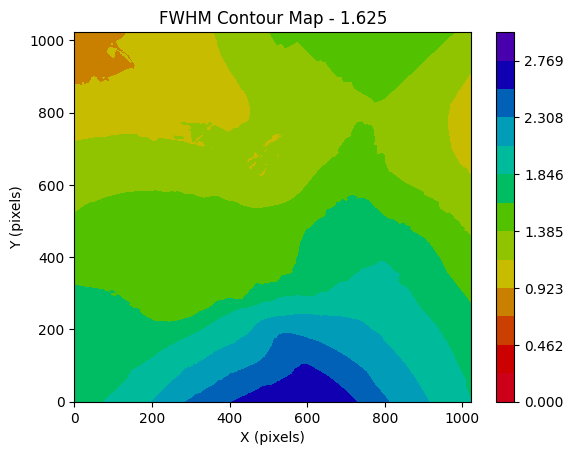

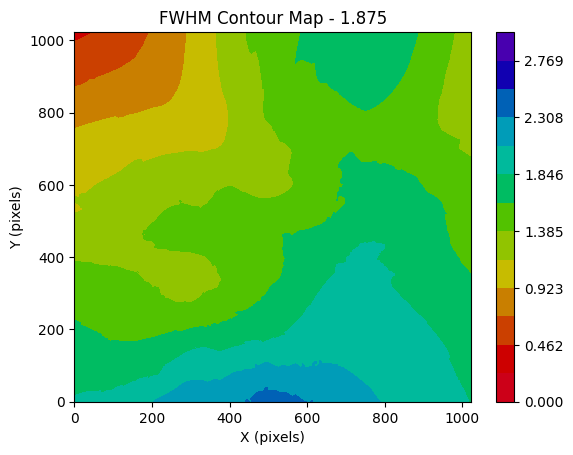

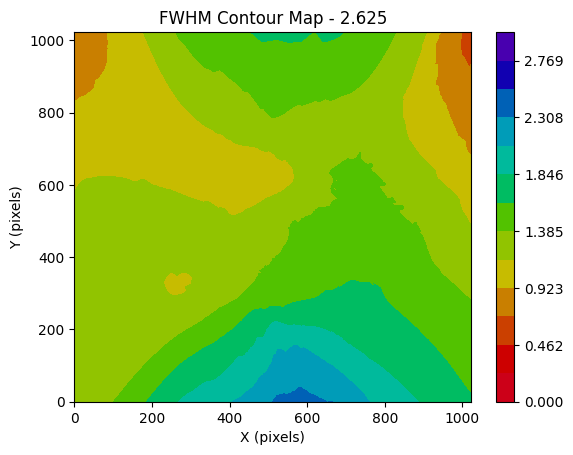

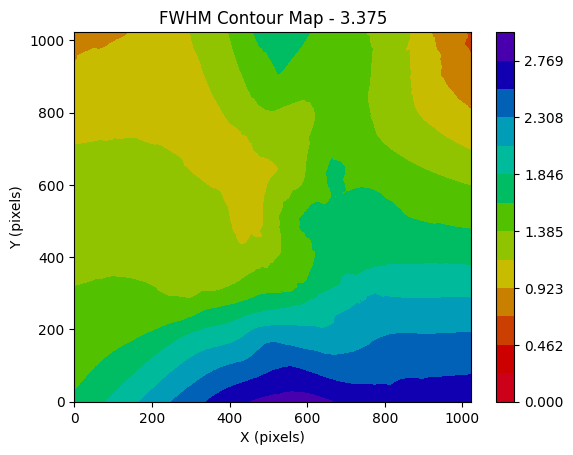

In [4]:
reddir = Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-06-26/raw-reduced/')
directories = [dir for dir in reddir.iterdir() if ('Focus' not in str(dir) and 'NGC' not in str(dir))]
graph_topographic(directories, condition_tuples=conditions_06_26, frac=0.5)

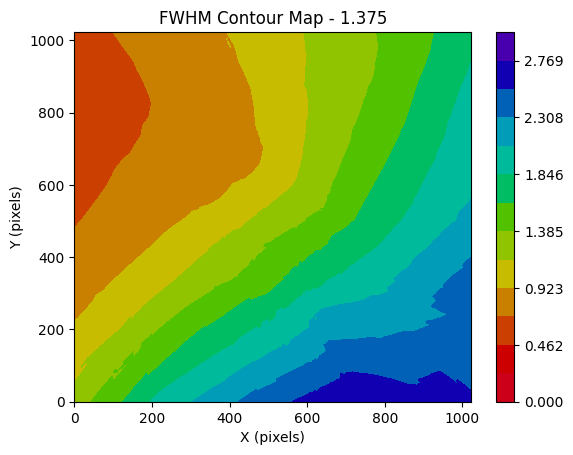

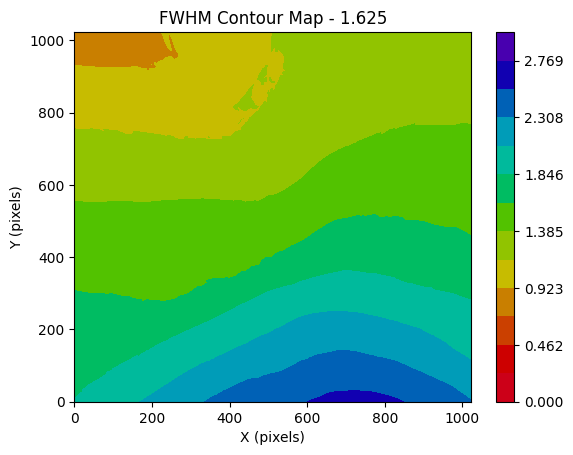

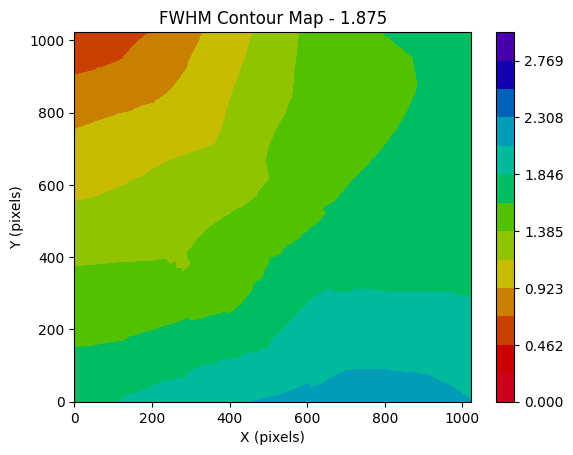

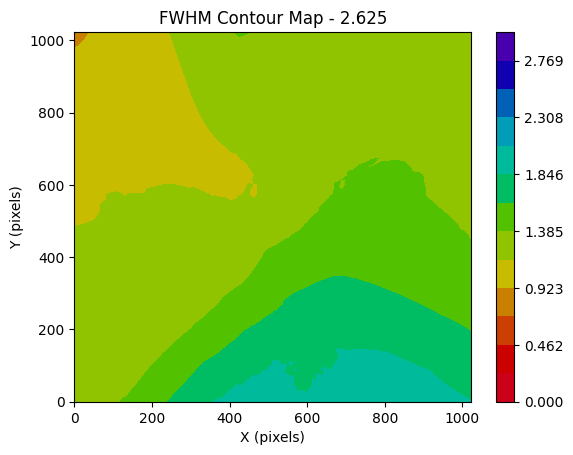

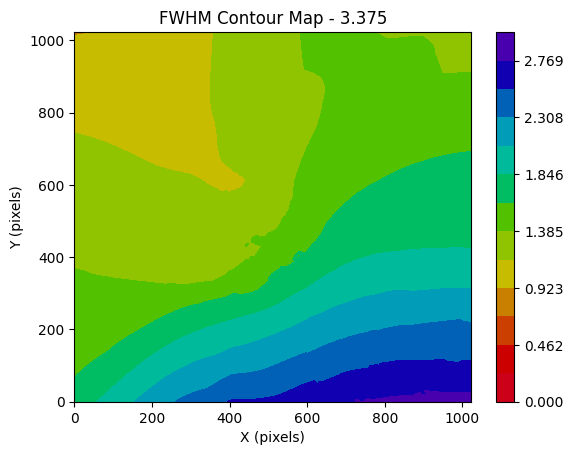

In [5]:
reddir = Path(f'C:/Users/allis/Documents/2024-2025_Local/Akamai Internship/pipeline-testing/test-data-06-26/raw-reduced/')
directories = [dir for dir in reddir.iterdir() if ('Focus' not in str(dir) and 'NGC' not in str(dir))]
graph_topographic(directories, condition_tuples=conditions_06_26, frac=0.7)